<a href="https://colab.research.google.com/github/GabrielGuilherme88/analises/blob/main/TAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Elaboração de scripts em python para análise de dados referente ao estudo demandado pela Agência Nacional de Saúde (ANS)

Como série, estaremos analisando os dados da pesquisa de preços FIPE, voltada para a cesta de produtos da saúde e suas variações mensais.

Os dados foram coletados no IPEADATA (Instituto de Pesquisa Econômica) na sessão de macroeconomia. A periodicidade está mensal.

Foi feito um ajuste nos dados originais, excluindo dados que fossem anteriores a 1995 por conta do controle do processo inflacionário provindo do plano real (1994). Com isso evitamos grandes variaçõe em nossa amostra.

A metodologia adotada é com base no livro Econometria Básica de Damodar N. Gujarati e Dawn C. Porter em sua quinta edição.

Portanto, seguiremos a análise na ordem:
1° será feito uma plotagem dos dados, assim como sua distribuição.
2° plotagem para verificar a existência de sazonalidade
3° plotagem os gráficos de autocorrelação e autocorrelação parcial (respectivamente ACF e PACF) para verificar White Noise e estacionáriedade (visualmente)
4° teste de estacionáriedade com o teste ADF para verificar o comportamento dos dados (se estão próximos de White Noise)
5° Estimação do modelo arima e de seus outputs estatísticos.


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 9.5MB 20.0MB/s 
     |████████████████████████████████| 2.1MB 51.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
#Carregando as bibliotecas necessárias para a análise.
import pandas as pd
import numpy as np
import seaborn as sns
import io
from google.colab import files
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample


In [ ]:
# Importa dados com indexador. Os dados estão armazenados em meu github pessoal
df = pd.read_csv("https://gist.githubusercontent.com/GabrielGuilherme88/d09a4c6aeeb870170fefbf207cee554a/raw/3e6267fb8f4a7105d56736e18540d69146a1891d/TESTE%2520P.csv",
                 delimiter=';', header=0, index_col= 0)

In [ ]:
#Para verificar se os dados foram importados 
df.head()

,Precos_FIPE,media,DP_plus,DP_sub
Data,,,,
1995.10,0.0129,0.007158,0.023456,-0.006544
1995.11,0.0045,0.007158,0.023456,-0.006544
1995.12,0.0288,0.007158,0.023456,-0.006544
1996.01,0.0277,0.007158,0.023456,-0.006544
1996.02,0.0092,0.007158,0.023456,-0.006544


In [ ]:
#Para retirar os anos próximos ao inicio do plano real
df.drop(df.index[:15], inplace=True)

In [ ]:
#Estatística descritiva da FIPE saúde
df["Precos_FIPE"].describe()

count    304.000000
mean       0.006056
std        0.005444
min       -0.006099
25%        0.002789
50%        0.004806
75%        0.007996
max        0.043900
Name: Precos_FIPE, dtype: float64

<Figure size 1296x576 with 0 Axes>

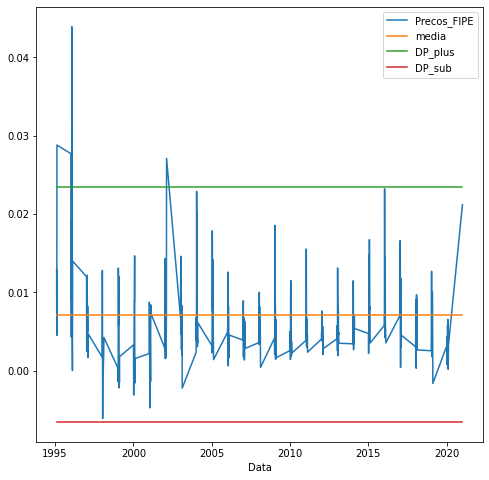

In [ ]:
#Gráfico para visualizar a média e desvio padrão. Aparentemente trata-se de uma série white noise estacionária. 
plt.figure(figsize=(18, 8))
df.plot()

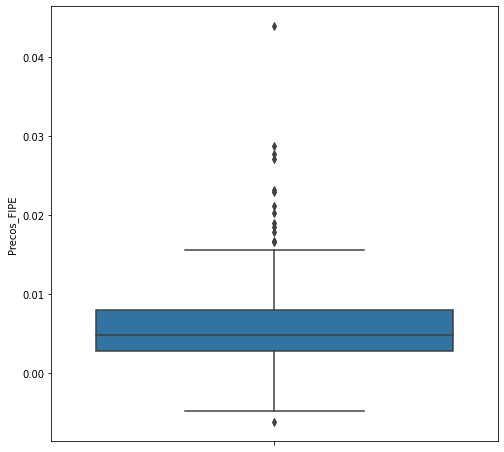

In [ ]:
#Para verificar a distribuição dos dados através de um boxplot. Isso ajuda a observar outliers
sns.boxplot(y="Precos_FIPE", data=df)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


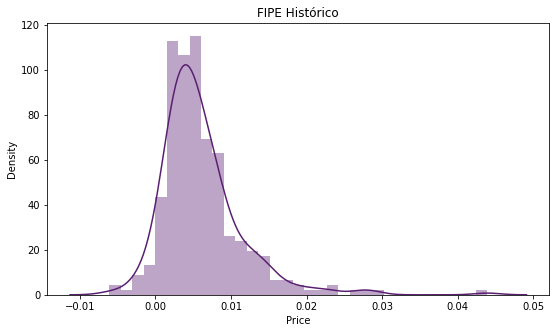

In [ ]:
#Gráfico de distribuição para análisar medidas de centralidade da amostra.
sns.set_color_codes(palette='dark')

f, ax = plt.subplots(figsize=(9, 5))
sns.distplot(df['Precos_FIPE'], color="m", axlabel='Price')
ax.set(title="FIPE Histórico")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 576x576 with 0 Axes>

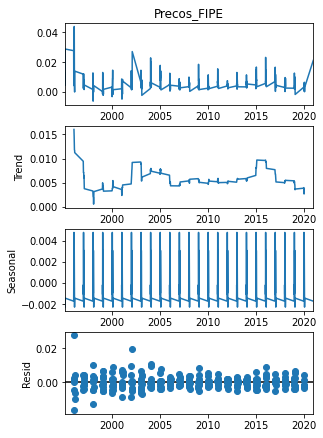

In [ ]:
#Gráficos para verificar sazonalidade, tendência e resíduos.
result = seasonal_decompose(df['Precos_FIPE'], model='additive', freq=12)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(4, 6)

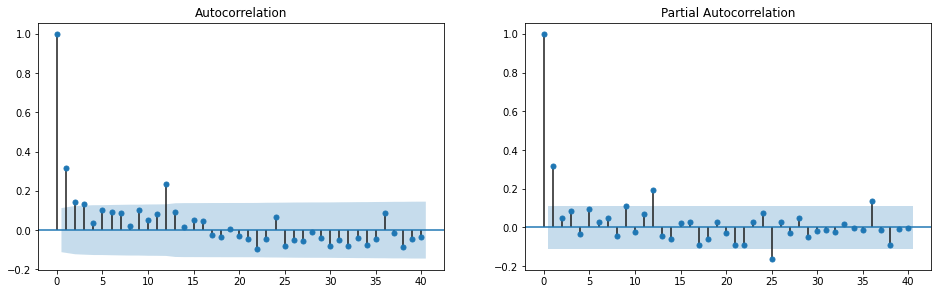

In [ ]:
#uma função para calcular e plotar a autocorrelação e autocorrelação parcial da FIPE saúde
#Aparentemente os dados não possuem forte relação com seus próprios erros ao longo de suas defasagem. Isso indica que é necessário no máximo 2 defasagens no modelo ARIMA
#Também temos indicío de que se trata de uma série estacinária.
def acf_pacf(x):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax2)
acf_pacf(df["Precos_FIPE"])

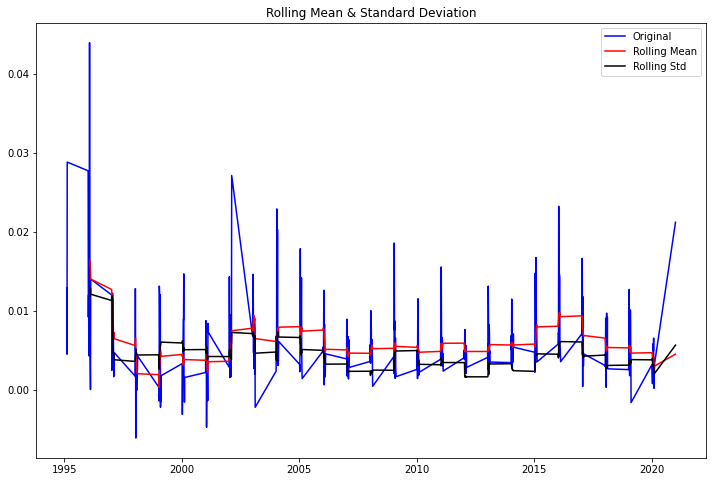

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.098654
p-value                          0.000014
#Lags Used                      11.000000
Number of Observations Used    292.000000
Critical Value (1%)             -3.452945
Critical Value (5%)             -2.871490
Critical Value (10%)            -2.572071
dtype: float64


In [ ]:
#Para verificar a estacionáriedade, podemos utilizar o teste ADF.
#O código abaixo cria uma função que irá realizar o teste em nossa variável chave, assim como plotar um gráfico com suas defasagens regredidas. 
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
test_stationarity(df['Precos_FIPE'])

In [ ]:
#Verifica através da estatística de AIC qual melhor nível de parâmetros (p,d,q) para otimizar o modelo.
res = sm.tsa.arma_order_select_ic(df["Precos_FIPE"], ic=["aic", "bic"], trend="c")
res.aic_min_order
res.bic_min_order

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-para

(1, 0)

In [ ]:
#SARIMAX: Modelo moderno, baseado no ARIMA, mas com ajustes exponenciais, sazonais...
mod = sm.tsa.statespace.SARIMAX(df["Precos_FIPE"],
                                order=(3, 1, 3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                          Precos_FIPE   No. Observations:                  304
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                1114.194
Date:                              Mon, 15 Feb 2021   AIC                          -2210.389
Time:                                      19:17:47   BIC                          -2177.838
Sample:                                           0   HQIC                         -2197.325
                                              - 304                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1306      0.272     -4.160      0.000      -1.663      -0.598
ar.L2         -0.46

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


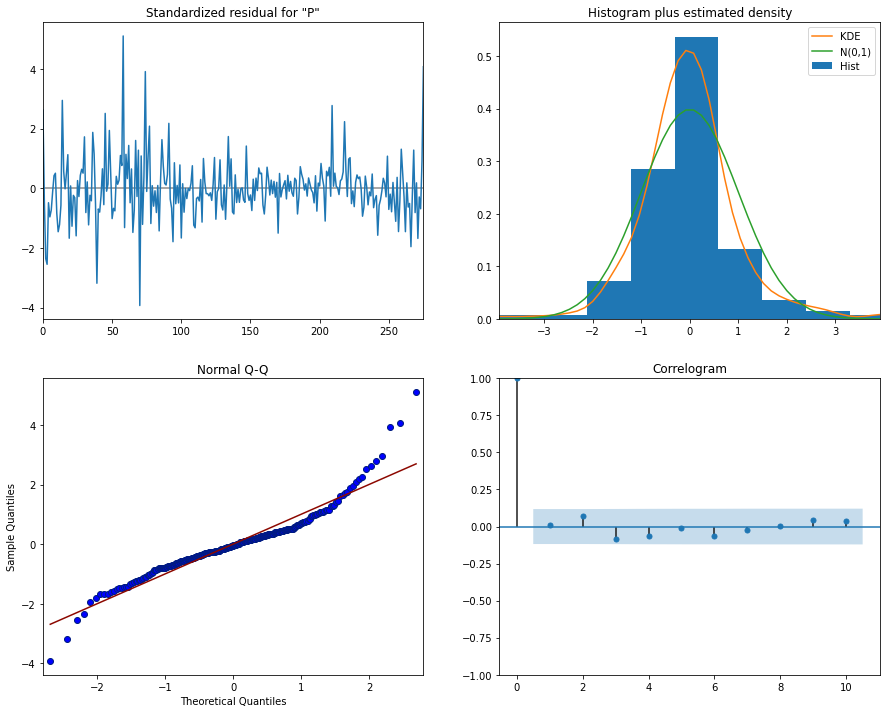

In [ ]:
#Análise dos resíduos. Aparenmente, os resíduos são estacionários e possuem uma distribuição normal.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

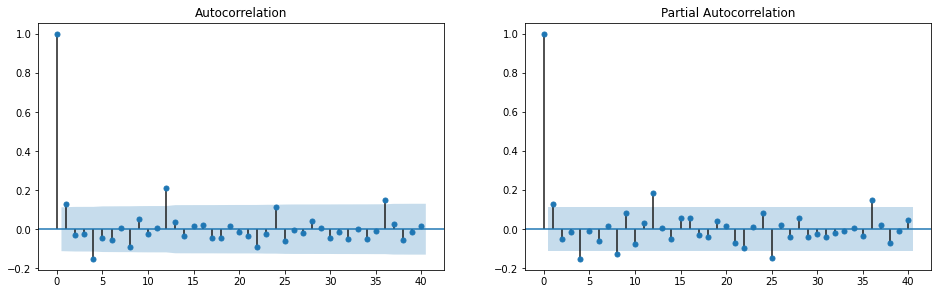

In [ ]:
#gráfico de autocorrelação e autocorrelação parcial, indicando que os resíduos estão não autocorrelacionados, ou seja, são estacionários.
residuals = results.resid
acf_pacf(residuals)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


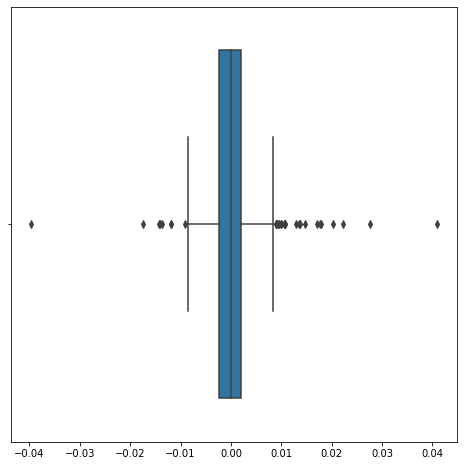

In [ ]:
#boxplot para verificar a distribuição e outliers dos resíduos. Esse gráfico reforça o comportamento aceitável dos resíduos.
sns.boxplot(results.resid, data=df)

In [ ]:
#(3,0,3) 2.8044719169477e-05
#(3, 2, 3) 3.5221037358062634e-05
# (1, 0, 0) 3.4332526572678855e-05
#(1, 0, 1) 2.8751146442134314e-05
# seasonal_order=(1, 1, 0, 12), (1, 0, 1) 3.9501835729238255e-0
results.mse

3.7329101826866805e-05

In [ ]:
#(3,0,3) 0.003488782759724069
#(3, 2, 3) 0.003924662400180703
#(1, 0, 0) 0.0039052999098628514
#(1, 0, 1) 0.0035935582683087053
# seasonal_order=(1, 1, 0, 12), (1, 0, 1) 0.003948416702997961
results.mae

0.0036203650104658165

In [ ]:
#(3,0,3) 0.008525594627521008
#(3, 2, 3) 0.010707195356851041
#(1, 0, 0) 0.010437088078094372
#(1, 0, 1) 0.008740348518408832
# seasonal_order=(1, 1, 0, 12), (1, 0, 1) 0.01200855806168843
results.sse

0.01134804695536751

In [ ]:
#Projeção
teste2 = results.forecast(96, alpha=0.05)
teste2.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


304    0.008406
305    0.002164
306    0.013238
307    0.005126
308    0.003725
Name: predicted_mean, dtype: float64

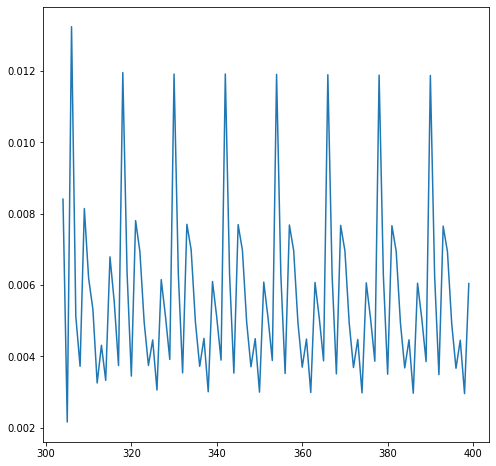

In [ ]:
#Gráfico de projeção
teste2.plot()

In [ ]:
#Exporta para CSV o objeto teste2
teste2.to_csv('teste2.csv')